# <span style = 'color: red'>**Práctica tres.** Aprendizaje de máquina. *Clusterización*</span>

# ***Parte dos.*** **Comparación de métodos de clusterización.**

## **Simón Cuartas Rendón**

En este *notebook* de Python se aborda el desarrollo de la **segunda parte** de la *práctica tres* del curso de **Aprendizaje de Máquina**, relacionada con la clusterización vía *KMeans*, clusterización aglomerativa, DBSCAN y clusterización espectral. Para cada una de estas alternativas se va a jugar con algunos de sus parámetros de cara a ver cuál consigue optimizar el índice de silueta.

A continuación, se abren los paquetes que se usarán para dar solución al problema propuesto.

**Anotación**. Este *notebook* está disponible en línea para facilitar su revisión. Se puede acceder al repositorio de *GitHub* aquí, y en particular, a [este](https://github.com/scuartasr/aprendmaq_entregable_3) cuaderno [aquí](https://github.com/scuartasr/aprendmaq_entregable_3/blob/main/Cuadernos/02_clusterizacion.ipynb).

In [1]:
#
# Apertura de paquetes básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import geopandas as gpd
import matplotlib.colors as mcolors
import os

# Paquetes de clusterización
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    DBSCAN,
    SpectralClustering,
)
from sklearn.metrics import silhouette_score

## <span style = 'color: cyan'>***2.1***</span> Lectura de datos

Se van a leer los datos preprocesados.

In [2]:
#
# Apertura de datos
direc = '../Datos/Preprocesamiento/paises_scaled.csv.zip'               # Datos estandarizados
direc_noest = '../Datos/Preprocesamiento/paises_original.csv.zip'       # Datos sin estandarizar
paises = pd.read_csv(direc, index_col=0, compression='zip', )
paises_noest = pd.read_csv(direc_noest, index_col=0, compression='zip', )

# Dimensionalidad
print(
    f'Los datos tienen {paises.shape[0]} filas y {paises.shape[1]} columnas.'
)

Los datos tienen 167 filas y 8 columnas.


In [3]:
#
# Primeras y últimas cinco observaciones
pd.concat(
    [paises.head(), paises.tail()],
    axis=0,
    keys=['Primeras cinco observaciones', 'Últimas cinco observaciones'],
)

exports    health  \
                             country                                   
Primeras cinco observaciones Afghanistan         -1.138280  0.279088   
                             Albania             -0.479658 -0.097016   
                             Algeria             -0.099122 -0.966073   
                             Angola               0.775381 -1.448071   
                             Antigua and Barbuda  0.160668 -0.286894   
Últimas cinco observaciones  Vanuatu              0.200917 -0.571711   
                             Venezuela           -0.461363 -0.695862   
                             Vietnam              1.130305  0.008877   
                             Yemen               -0.406478 -0.597272   
                             Zambia              -0.150348 -0.338015   

                                                   imports    income  \
                             country                                   
Primeras cinco observaciones Afghanistan         -0.082455 -0.808245   
                             Albania              0.070837 -0.375369   
                             Algeria             -0.641762 -0.220844   
                             Angola              -0.165315 -0.585043   
                             Antigua and Barbuda  0.497568  0.101732   
Últimas cinco observaciones  Vanuatu              0.240700 -0.738527   
                             Venezuela           -1.213499 -0.033542   
                             Vietnam              1.380030 -0.658404   
                             Yemen               -0.517472 -0.658924   
                             Zambia              -0.662477 -0.721358   

                                                  inflation  life_expec  \
                             country                                      
Primeras cinco observaciones Afghanistan           0.157336   -1.619092   
                             Albania              -0.312347    0.647866   
                             Algeria               0.789274    0.670423   
                             Angola                1.387054   -1.179234   
                             Antigua and Barbuda  -0.601749    0.704258   
Últimas cinco observaciones  Vanuatu              -0.489784   -0.852161   
                             Venezuela             3.616865    0.546361   
                             Vietnam               0.409732    0.286958   
                             Yemen                 1.500916   -0.344633   
                             Zambia                0.590015   -2.092785   

                                                  total_fer      gdpp  
                             country                                   
Primeras cinco observaciones Afghanistan           1.902882 -0.679180  
                             Albania              -0.859973 -0.485623  
                             Algeria              -0.038404 -0.465376  
                             Angola                2.128151 -0.516268  
                             Antigua and Barbuda  -0.541946 -0.041817  
Últimas cinco observaciones  Vanuatu               0.365754 -0.546913  
                             Venezuela            -0.316678  0.029323  
                             Vietnam              -0.661206 -0.637754  
                             Yemen                 1.140944 -0.637754  
                             Zambia                1.624609 -0.629546

Nótese que el marco de datos leído conserva la dimensionalidad que se obtuvo en el *notebook* de preprocesamiento, y que el nombre de cada país corresponde a la etiqueta de cada instancia, por lo que no será involucrado en el proceso de clusterización propiamente.

**Importante.** Más adelante se graficarán mapas que permitan ver a qué clúster se asigna cada nación. Para permitir esto, es necesario corregir los índices en las bases, como se muestra enseguida:

In [4]:
# 
# Correcciones
correcciones = {
    "Bahamas": "The Bahamas",
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Congo, Rep.": "Republic of the Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Gambia": "The Gambia",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao": "Laos",
    "Macedonia, FYR": "North Macedonia",
    "Micronesia, Fed. Sts.": "Federated States of Micronesia",
    "Russia": "Russia",
    "Slovak Republic": "Slovakia",
    "South Korea": "South Korea",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "United States": "United States of America",
    "Vatican City": "Vatican",
}

# Aplicación

paises = paises.copy()
paises['country_corrected'] = paises.index.to_series().replace(correcciones)
paises.set_index('country_corrected', inplace=True)

paises_noest = paises_noest.copy()
paises_noest['country_corrected'] = paises_noest.index.to_series().replace(correcciones)
paises_noest.set_index('country_corrected', inplace=True)



## <span style = 'color: cyan'>***2.2***</span> *KMeans*

Se iniciará con *KMeans*. Para este, se jugará con el parámetro del número de clústeres.

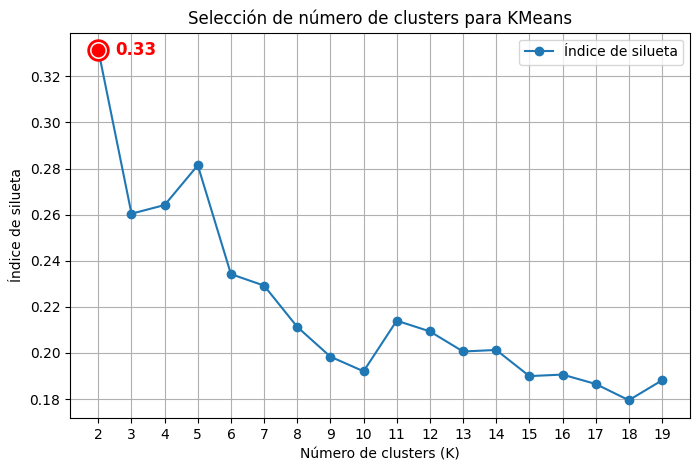

El mejor número de clusters es 2 con un índice de silueta de 0.33.


In [5]:
#
# Gráfico del indicador de silueta en función del número de clústeres

range_n_clusters = range(2, 20)
sil_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(paises)
    sil = silhouette_score(paises, labels)
    sil_scores.append(sil)

# Optimización
max_score = max(sil_scores)
max_idx = sil_scores.index(max_score)
max_k = range_n_clusters[max_idx]

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, sil_scores, marker='o', label="Índice de silueta")
plt.scatter(max_k, max_score, s=200, c='white', edgecolors='red', linewidths=2, zorder=5)
plt.scatter(max_k, max_score, s=80, c='red', zorder=6)
plt.xticks(range_n_clusters)

# Etiqueta a la izquierda del punto óptimo
plt.text(max_k + 1.75, max_score, f"{max_score:.2f}", ha='right', va='center', 
         fontsize=12, fontweight='bold', color='red')

plt.xlabel("Número de clusters (K)")
plt.ylabel("Índice de silueta")
plt.title("Selección de número de clusters para KMeans")
plt.grid(True)
plt.legend()
plt.show()

# Mejor número de clusters
print(f'El mejor número de clusters es {max_k} con un índice de silueta de {max_score:.2f}.')


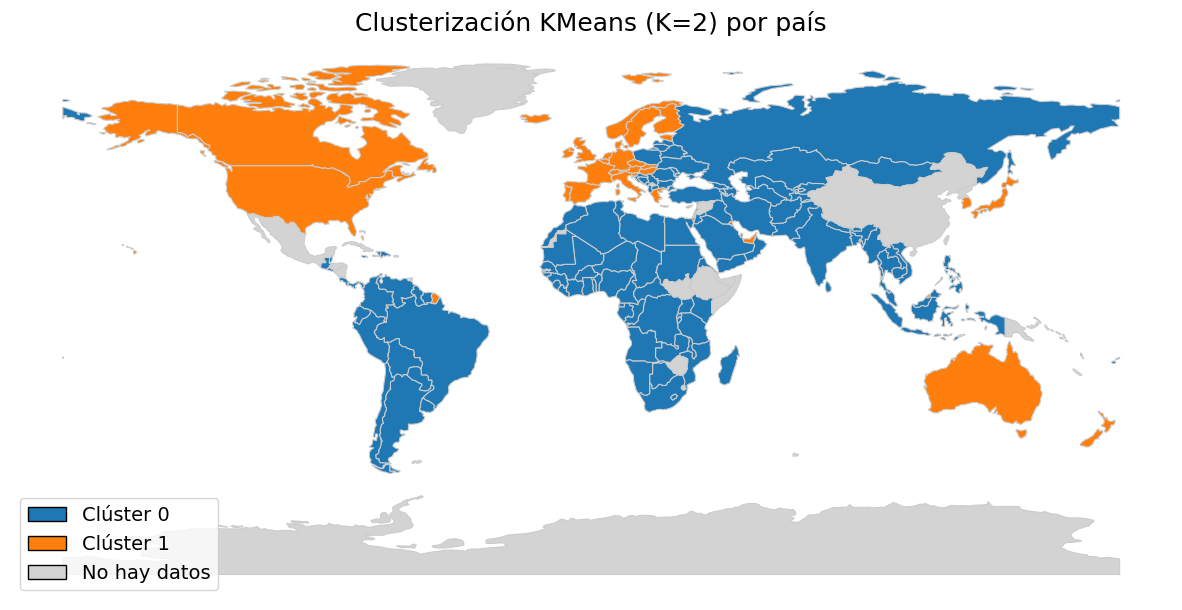

In [6]:
#
# Ajuste con el valor óptimo
kmeans = KMeans(n_clusters=max_k, random_state=42)
labels = kmeans.fit_predict(paises)

result = paises.copy()
result['cluster'] = labels

# Shapefile para generar gráfico
shapefile_path = '../Datos/Mapas/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
merged = world.merge(result, left_on='NAME_EN', right_index=True, how='left')

colores = ['#1f77b4', '#ff7f0e']  
cmap = mcolors.ListedColormap(colores)

# Mapa
fig, ax = plt.subplots(figsize=(15, 10))
merged.plot(
    column='cluster',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=False,
    missing_kwds={
        "color": "lightgrey",
        "label": "No hay datos"
    }
)
ax.set_title(f'Clusterización KMeans (K={max_k}) por país', fontsize=18)
ax.axis('off')

legend_elements = [
    Patch(facecolor=colores[0], edgecolor='k', label='Clúster 0'),
    Patch(facecolor=colores[1], edgecolor='k', label='Clúster 1'),
    Patch(facecolor='lightgrey', edgecolor='k', label='No hay datos'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14)

plt.show()


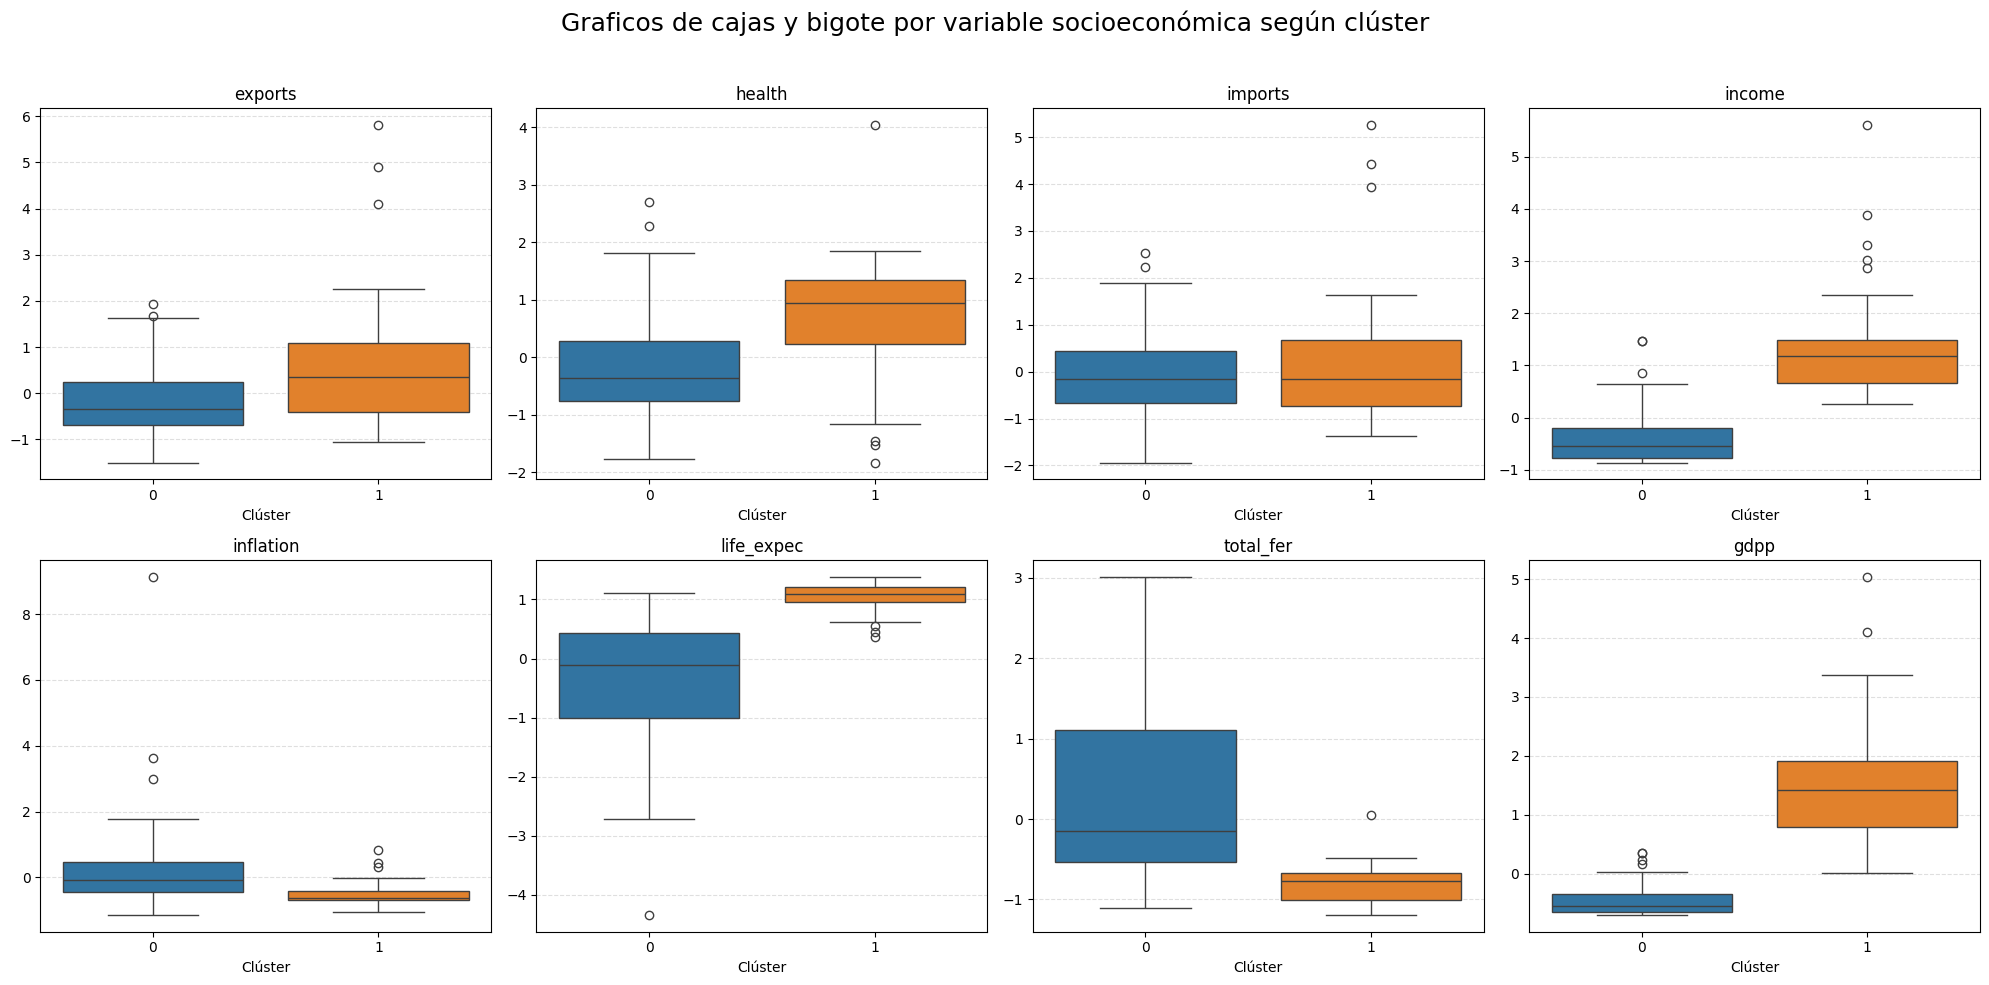

In [7]:
#
# Gráficos de boxplot para análisis
result_reset = result.reset_index().rename(columns={'index': 'country'})
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, var in enumerate(paises.columns.tolist()):
    ax = axs[i // 4, i % 4]
    sns.boxplot(
        data=result_reset,
        x='cluster',
        y=var,
        hue='cluster',
        palette=['#1f77b4', '#ff7f0e'],
        legend=False,
        ax=ax
    )
    ax.set_title(var)
    ax.set_xlabel('Clúster')
    ax.set_ylabel('')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
fig.suptitle('Graficos de cajas y bigote por variable socioeconómica según clúster', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
#
# Cantidad de instancias asignadas a cada clúster
print(
    result['cluster'].value_counts().sort_index(),
    result['cluster'].value_counts(normalize=True).sort_index(),
    sep='\n\n')

cluster
0    128
1     39
Name: count, dtype: int64

cluster
0    0.766467
1    0.233533
Name: proportion, dtype: float64


<span style = 'color: red'>***Análisis técnico.***</span> De acuerdo con *Kmeans*, para este marco de datos es posible separar a los datos en dos grupos, que son los que se observan en el gráfico, ya que maximiza el indicador de silueta. Un aspecto que se puede observar del gráfico es que en azul (clúster `0`) han quedado marcados los países del *norte global* y en naranja (clúster `1`) los del *sur global*, siendo los primeros típicamente más desarrollados y con economías y sistemas de bienestar más robustos frente a los segundos. Esto se evidencia en los gráficos de cajas y bigotes, donde se evidencia que los países del clúster `0` suelen tener indicadores con medianas más bajas que las del clúster `1` para medidas positivas como las exportaciones, mientras que para las negativas puede ser al revés, como es el caso de la inflación. De manera descriptiva, se puede decir que los países del clúster `1` tienen ingresos, PIB per capita y esperanzas de vida en promedio mayores que los países del clúster `0`.

<span style = 'color: red'>***Análisis de negocio.***</span> Claramente los países que requerirían recursos de la ONG son los del clúster `0`. No obstante, esto podría ser poco adecuado ya que son 128 las naciones que han sido agrupadas en dicho segmento. En este orden de ideas, valdría la pena ver el resultado que se derivaría de tomar una mayor cantidad de clústeres. Para ello, se va a considerar $k = 4$, ya que es el segundo mejor resultado con un indicador de silueta por encima de $0.28$.

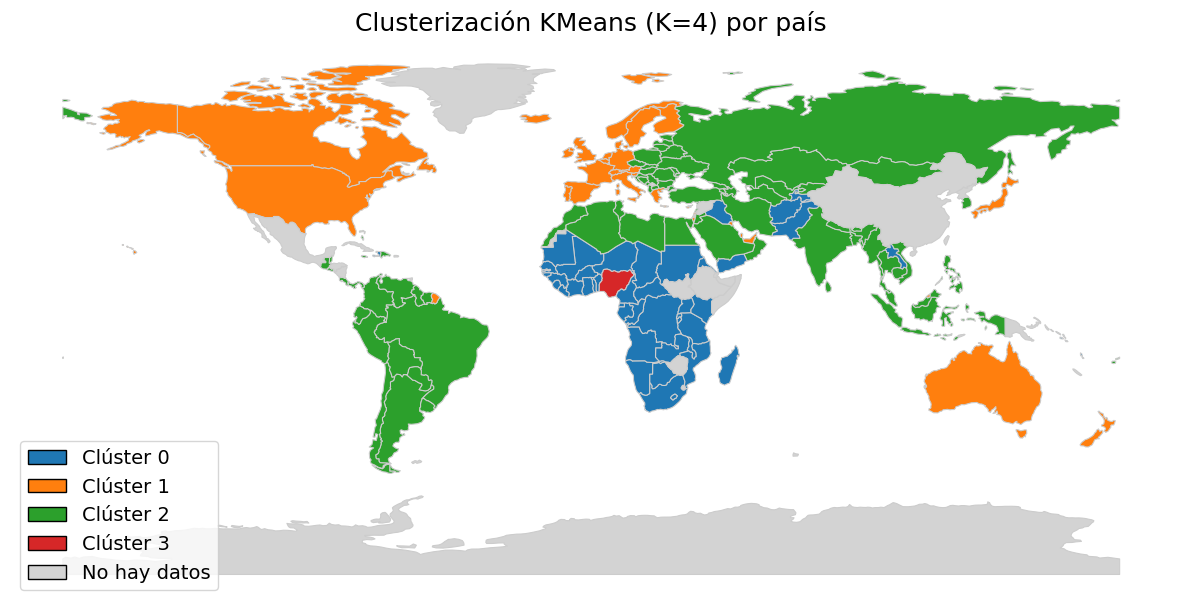

In [9]:
#
# Kmeans con cuatro clústeres
max_k = 4  # Ahora trabajamos con 4 clústeres
kmeans = KMeans(n_clusters=max_k, random_state=42)
labels = kmeans.fit_predict(paises)

result = paises.copy()
result['cluster'] = labels

# Mapa
merged = world.merge(result, left_on='NAME_EN', right_index=True, how='left')
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # azul, naranja, verde, rojo
cmap = mcolors.ListedColormap(colores)

fig, ax = plt.subplots(figsize=(15, 10))
merged.plot(
    column='cluster',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=False,
    missing_kwds={
        "color": "lightgrey",
        "label": "No hay datos"
    }
)
ax.set_title(f'Clusterización KMeans (K={max_k}) por país', fontsize=18)
ax.axis('off')

# Leyenda
legend_elements = [
    Patch(facecolor=colores[0], edgecolor='k', label='Clúster 0'),
    Patch(facecolor=colores[1], edgecolor='k', label='Clúster 1'),
    Patch(facecolor=colores[2], edgecolor='k', label='Clúster 2'),
    Patch(facecolor=colores[3], edgecolor='k', label='Clúster 3'),
    Patch(facecolor='lightgrey', edgecolor='k', label='No hay datos'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14)

plt.show()


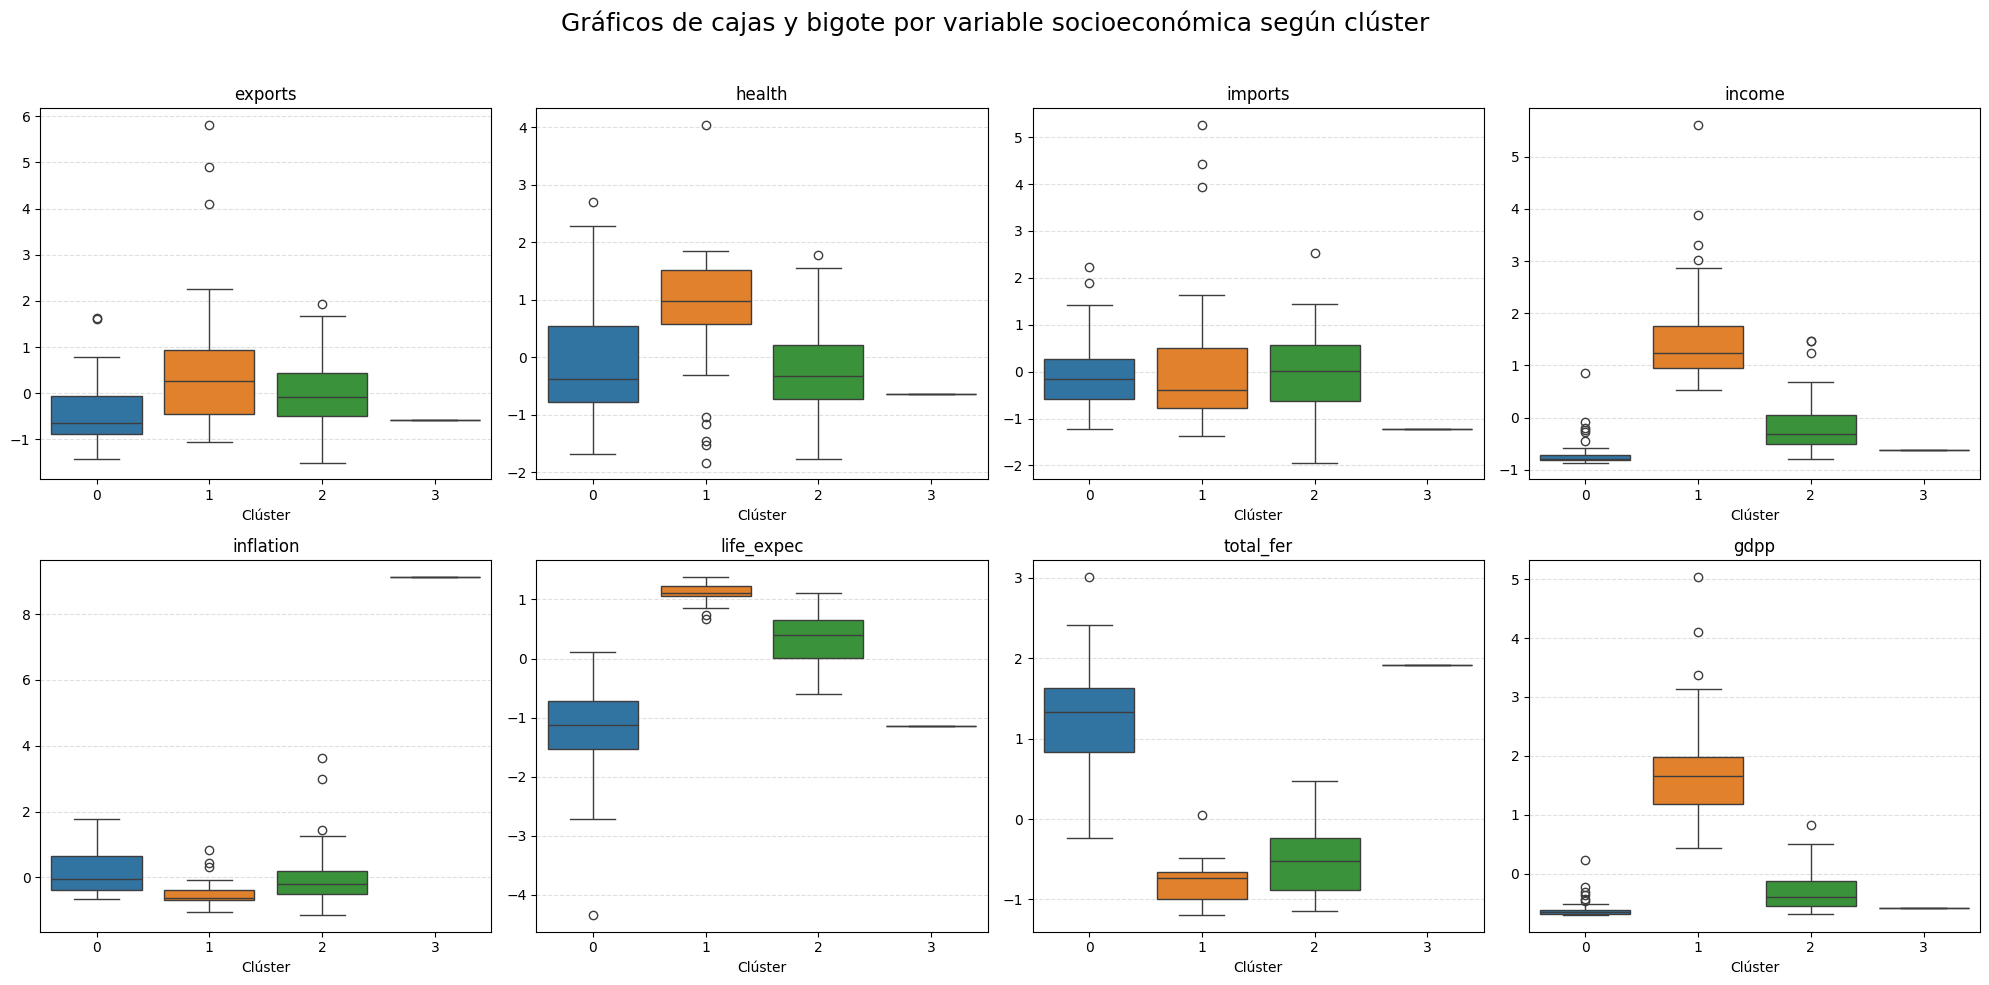

In [11]:
#
# Gráficos de boxplot para análisis
palette_4 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

result_reset = result.reset_index().rename(columns={'index': 'country'})
variables = paises.columns.tolist()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, var in enumerate(variables):
    ax = axs[i // 4, i % 4]
    sns.boxplot(
        data=result_reset,
        x='cluster',
        y=var,
        hue='cluster',
        palette=palette_4,
        legend=False,
        ax=ax
    )
    ax.set_title(var)
    ax.set_xlabel('Clúster')
    ax.set_ylabel('')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.suptitle('Gráficos de cajas y bigote por variable socioeconómica según clúster', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [12]:
#
# Cantidad de instancias asignadas a cada clúster
print(
    result['cluster'].value_counts().sort_index(),
    result['cluster'].value_counts(normalize=True).sort_index(),
    sep='\n\n')

cluster
0    52
1    32
2    82
3     1
Name: count, dtype: int64

cluster
0    0.311377
1    0.191617
2    0.491018
3    0.005988
Name: proportion, dtype: float64


<span style = 'color: red'>***Análisis técnico.***</span> Si bien cuando se toma $k = 4$ no se maximica el índice de silueta, sí se obtiene el segundo mejor resultando, y como se observa, hay una mayor diseminación de países a lo largo de los primeros tres clústeres (en el último solo queda uno asignado). Así, es más fácil priorizar la asginación de recursos por parte de la ONG.

<span style = 'color: red'>***Análisis de negocio.***</span> Usando el ingreso, el PIB per capita y la esperanza de vida, es posible determinar que los países de los clústeres `0` y `3` son a los que se les pueden girar los recursos. A partir de estas y otras variables se puede determinar en qué tipo de programas se pueden invertir los recursos para cada nación: salud, educación, agua o empleo, entre otros. Observando el mapamundi, se ve que estos países se ubican en el África subsahariana y en Oriente Medio.

## <span style = 'color: cyan'>***2.3***</span> *Clusterización aglomerativa*

En este caso, se jugará con el número de clústeres en función de la función de enlace empleada.

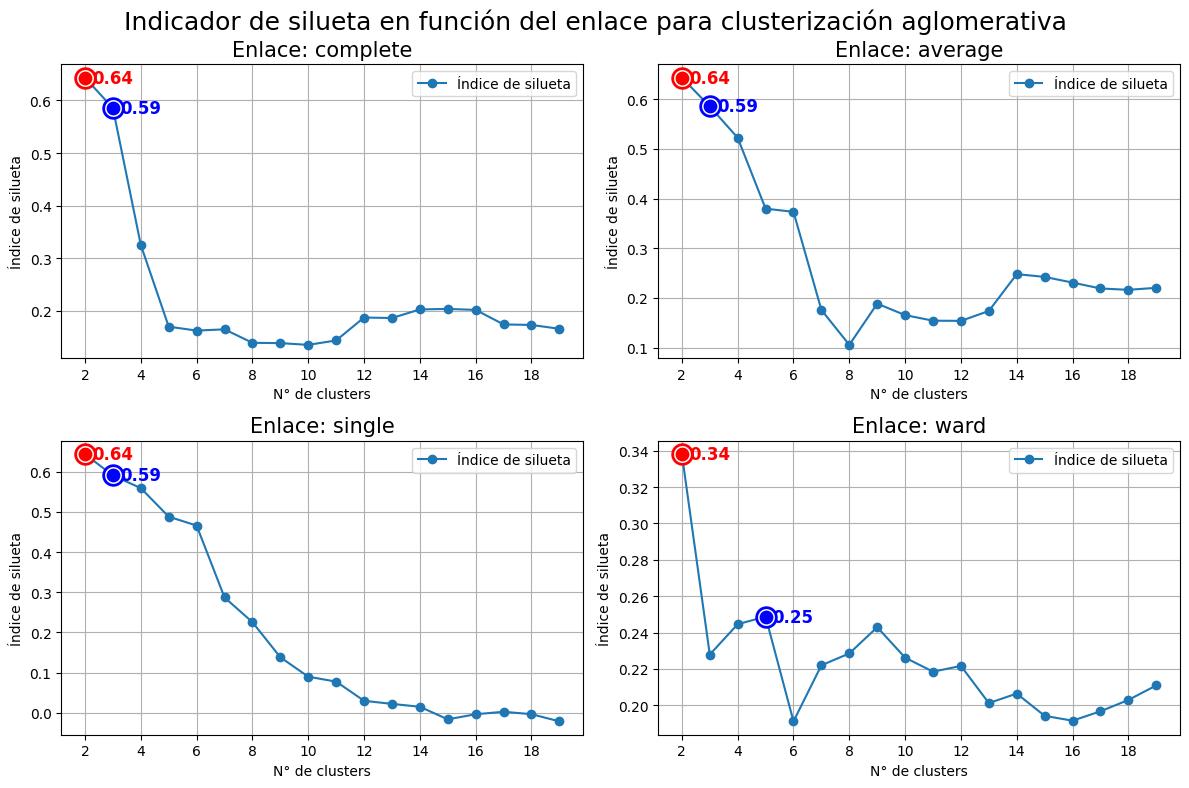

In [13]:
enlaces = ['complete', 'average', 'single', 'ward']
range_n_clusters = range(2, 20)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for idx, enlace in enumerate(enlaces):
    sil_scores = []
    for n_clusters in range_n_clusters:
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=enlace)
        labels = model.fit_predict(paises)
        sil = silhouette_score(paises, labels)
        sil_scores.append(sil)

    sil_scores_np = np.array(sil_scores)
    valid_idx = np.where(~np.isnan(sil_scores_np))[0]
    ax = axs[idx]
    ax.plot(range_n_clusters, sil_scores, marker='o', label="Índice de silueta")
    
    if len(valid_idx) > 0:
        
        sil_ord = valid_idx[np.argsort(-sil_scores_np[valid_idx])]
        
        max_idx = sil_ord[0]
        max_k = range_n_clusters[max_idx]
        max_score = sil_scores_np[max_idx]
        
        if len(sil_ord) > 1:
            second_idx = sil_ord[1]
            second_k = range_n_clusters[second_idx]
            second_score = sil_scores_np[second_idx]
        else:
            second_k, second_score = None, None

        
        ax.scatter(max_k, max_score, s=200, c='white', edgecolors='red', linewidths=2, zorder=5)
        ax.scatter(max_k, max_score, s=80, c='red', zorder=6)
        ax.text(max_k+0.25, max_score, f"{max_score:.2f}", ha='left', va='center', fontsize=12, fontweight='bold', color='red')
        
        if second_k is not None:
            ax.scatter(second_k, second_score, s=200, c='white', edgecolors='blue', linewidths=2, zorder=5)
            ax.scatter(second_k, second_score, s=80, c='blue', zorder=6)
            ax.text(second_k+0.25, second_score, f"{second_score:.2f}", ha='left', va='center', fontsize=12, fontweight='bold', color='blue')

    ax.set_title(f'Enlace: {enlace}', fontsize=15)
    ax.set_xlabel("N° de clusters")
    ax.set_ylabel("Índice de silueta")
    ax.grid(True)
    ax.legend()


for ax in axs:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Indicador de silueta en función del enlace para clusterización aglomerativa", fontsize=18)
plt.show()


<span style = 'color: red'>***Análisis técnico.***</span> Nuevamente, el indicador de silueta se maximiza cuando se toman dos clústeres. Para los enlaces `complete`, `average` y `single` se obtienen indicadores que duplican el mejor resultado con *KMeans*. Ahora, se mostrará cuántos países quedan cuando se toman entre dos y seis clústeres, pues como se ve, en estos valores se logra maximizar el indicador de silueta.

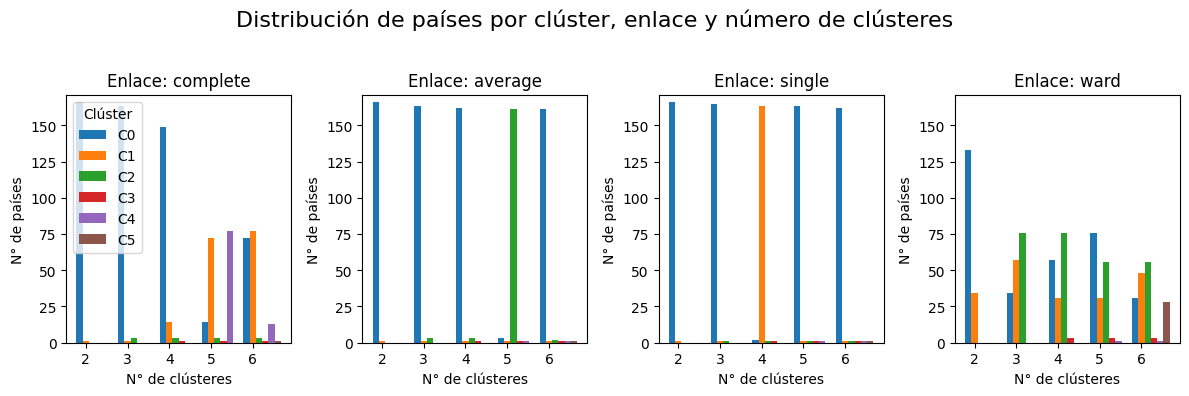

In [14]:
#
enlaces = ['complete', 'average', 'single', 'ward']
ks = [2, 3, 4, 5, 6]

# Guardar los conteos en una lista
data = []

for enlace in enlaces:
    for n_clusters in ks:
        try:
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=enlace)
            labels = model.fit_predict(paises)
            counts = pd.Series(labels).value_counts().sort_index()
            for clust, n in counts.items():
                data.append({'enlace': enlace, 'k': n_clusters, 'clúster': f'C{clust}', 'n_paises': n})
        except Exception as e:
            pass  # Si hay error, simplemente no agrega ese caso

# Convertir a DataFrame
df_bar = pd.DataFrame(data)

# Gráfico de barras agrupadas por enlace y k
g = plt.figure(figsize=(12, 4))
for i, enlace in enumerate(enlaces):
    ax = plt.subplot(1, len(enlaces), i+1)
    df_plot = df_bar[df_bar['enlace'] == enlace]
    # Gráfico de barras agrupadas por número de clusters
    for clust in df_plot['clúster'].unique():
        dfc = df_plot[df_plot['clúster'] == clust]
        ax.bar(dfc['k'] + 0.15 * (int(clust[-1]) - 1), dfc['n_paises'], width=0.15, label=clust)
    ax.set_title(f'Enlace: {enlace}')
    ax.set_xlabel('N° de clústeres')
    ax.set_ylabel('N° de países')
    ax.set_xticks(ks)
    ax.set_xticklabels(ks)
    if i == 0:
        ax.legend(title="Clúster")
    ax.set_ylim(0, df_bar['n_paises'].max() + 5)
plt.suptitle("Distribución de países por clúster, enlace y número de clústeres", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<span style = 'color: red'>***Análisis.***</span> Como se puede observar, a pesar de que con los primeros tres enlaces se consiguen muy buenos indicadores de silueta que superan con creces los del indicador `ward`, con este último enlace se obtiene una mejor distribución de los países entre los distintos clústeres. Con el enlace `complete` se obtiene un regultado adecuado cuando hay seis clústeres, pero los primeros dos tienen una gran concentración, desvirtuando nuevamente el propósito del análisis; además, con dicha cantidad de clústeres, el indicador de silueta es mejor para `ward`. Así, se conservará este como el ***mejor resultado de negocio*** y a continuación se grafica el mapamundi.

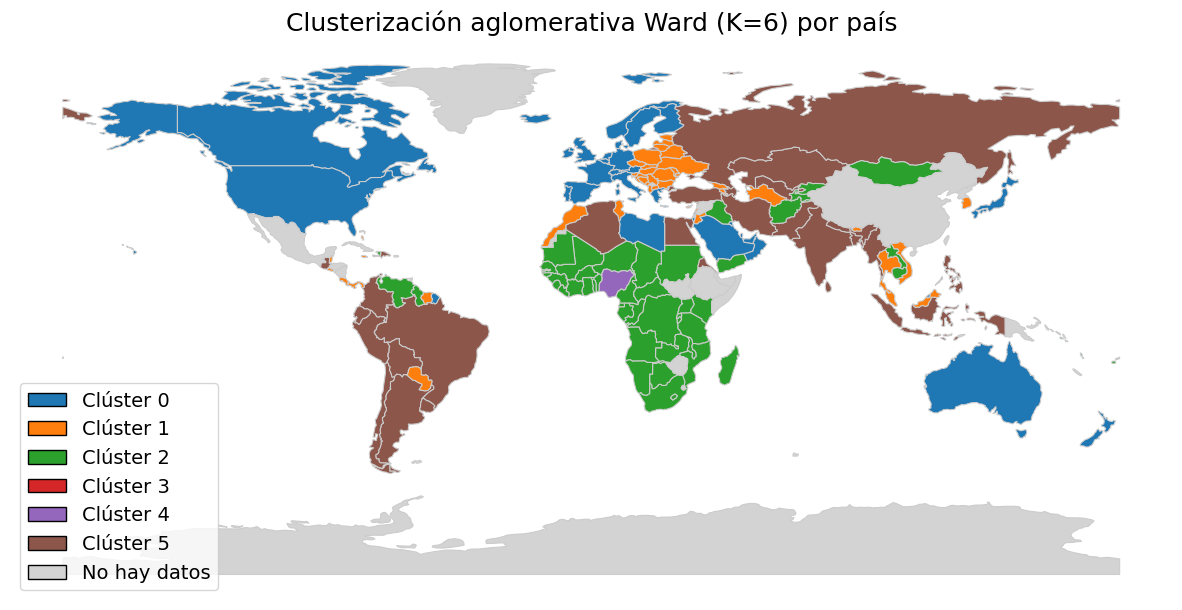

In [15]:
#
# Mapamundi con ward y seis clústeres
max_k = 6  # Seis clústeres
model = AgglomerativeClustering(n_clusters=max_k, linkage='ward')
labels = model.fit_predict(paises)

result = paises.copy()
result['cluster'] = labels

merged = world.merge(result, left_on='NAME_EN', right_index=True, how='left')

colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # 6 colores contrastantes
cmap = mcolors.ListedColormap(colores)

fig, ax = plt.subplots(figsize=(15, 10))
merged.plot(
    column='cluster',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=False,
    missing_kwds={
        "color": "lightgrey",
        "label": "No hay datos"
    }
)
ax.set_title(f'Clusterización aglomerativa Ward (K={max_k}) por país', fontsize=18)
ax.axis('off')

legend_elements = [
    Patch(facecolor=colores[0], edgecolor='k', label='Clúster 0'),
    Patch(facecolor=colores[1], edgecolor='k', label='Clúster 1'),
    Patch(facecolor=colores[2], edgecolor='k', label='Clúster 2'),
    Patch(facecolor=colores[3], edgecolor='k', label='Clúster 3'),
    Patch(facecolor=colores[4], edgecolor='k', label='Clúster 4'),
    Patch(facecolor=colores[5], edgecolor='k', label='Clúster 5'),
    Patch(facecolor='lightgrey', edgecolor='k', label='No hay datos'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14)

plt.show()


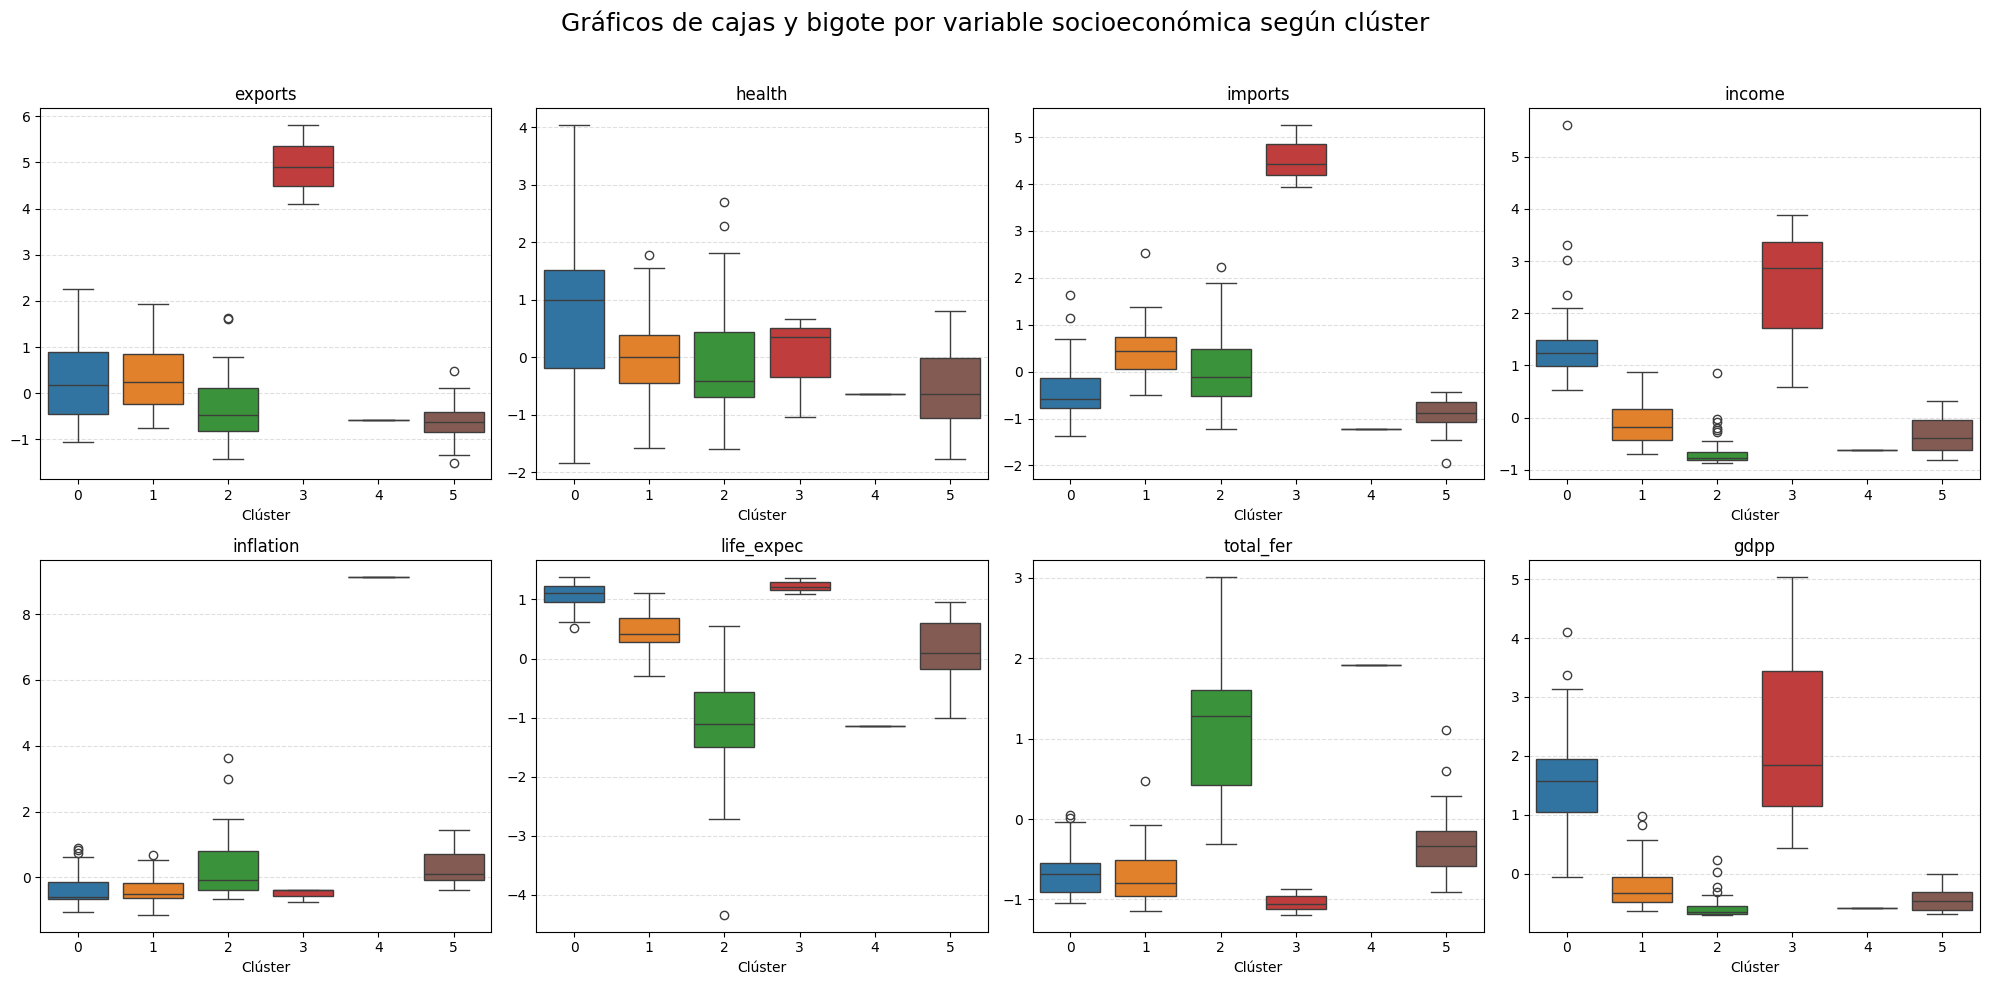

In [16]:
#
# Gráfico de cajas y bigote para análisis
result_reset = result.reset_index().rename(columns={'index': 'country'})
variables = paises.columns.tolist()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, var in enumerate(variables):
    ax = axs[i // 4, i % 4]
    sns.boxplot(
        data=result_reset,
        x='cluster',
        y=var,
        hue='cluster',
        palette=colores,
        legend=False,
        ax=ax
    )
    ax.set_title(var)
    ax.set_xlabel('Clúster')
    ax.set_ylabel('')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.suptitle('Gráficos de cajas y bigote por variable socioeconómica según clúster', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [17]:
#
# Cantidad de instancias asignadas a cada clúster
print(
    result['cluster'].value_counts().sort_index(),
    result['cluster'].value_counts(normalize=True).sort_index(),
    sep='\n\n')

cluster
0    31
1    48
2    56
3     3
4     1
5    28
Name: count, dtype: int64

cluster
0    0.185629
1    0.287425
2    0.335329
3    0.017964
4    0.005988
5    0.167665
Name: proportion, dtype: float64


<span style = 'color: red'>***Análisis de negocio.***</span> A partir del gráfico de cajas y bigotes, es posible priorizar tres clústeres: `2`, `4` y `5`, que agrupan 85 países (tres más que con *Kmeans*), ya que todos ellos muestran un peor desempeño en indicadores como la esperanza de vida o el PIB per capita. Geográficamente, se parece mucho al resultado de *KMeans*, pues se priorizarían países del África subsahariana y el Medio Oriente, si bien algunos saldrían de esta priorización e ingresarían algunos del Asia central y toda América del Sur, experto por la Guayana Francesa y Paraguay.

## <span style = 'color: cyan'>***2.4***</span> *DBSCAN*

En este caso, se jugará con el número mínimo de instancias que debe tener cada clúster (`n_samples`) y la distancia máxima entre dos instancias para poder conformar un mismo clúster (`eps`):

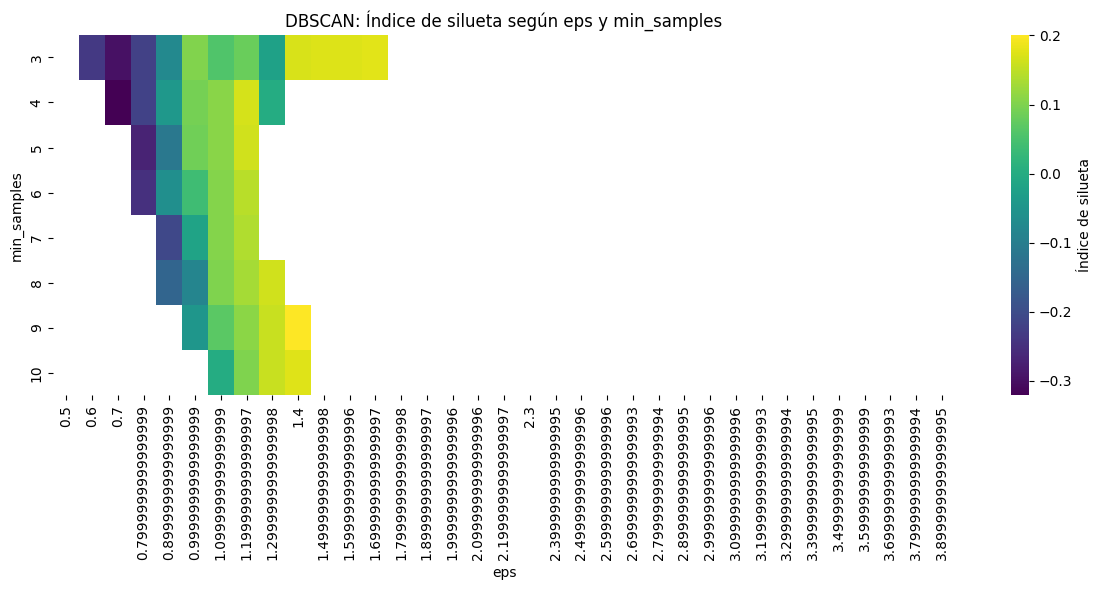

In [19]:
#
# Rango de hiperparámetros
eps_range = np.arange(0.5, 4.0, 0.1)
min_samples_range = range(3, 11)

# Guardar resultados
results = []

for min_samples in min_samples_range:
    for eps in eps_range:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(paises)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        # Solo calculamos silueta si hay al menos 2 clústeres y menos que total de puntos
        if n_clusters >= 2 and n_clusters < len(paises):
            sil = silhouette_score(paises, labels)
        else:
            sil = np.nan
        results.append({'min_samples': min_samples, 'eps': eps, 'silhouette': sil})

df_sil = pd.DataFrame(results)

# Hacer el heatmap (eps: eje X, min_samples: eje Y)
df_pivot = df_sil.pivot(index='min_samples', columns='eps', values='silhouette')

plt.figure(figsize=(12, 6))
sns.heatmap(df_pivot, annot=False, cmap="viridis", cbar_kws={'label': 'Índice de silueta'})
plt.title("DBSCAN: Índice de silueta según eps y min_samples")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.tight_layout()
plt.show()
